In [1]:
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'

In [2]:
import numpy as np
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2458740239870273860
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3150367948
locality {
  bus_id: 1
  links {
  }
}
incarnation: 4013066312909486213
physical_device_desc: "device: 0, name: GeForce GTX 1050 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [3]:
from keras import backend as K
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
K.tensorflow_backend._get_available_gpus()

Using TensorFlow backend.


['/job:localhost/replica:0/task:0/device:GPU:0']

In [4]:
import re
import tensorflow as tf
from keras.models import Sequential
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.models import Model
from keras.layers import Dense, Input, Flatten
from keras.layers import Conv1D, MaxPooling1D, Embedding, merge, Dropout, LSTM, GRU, Bidirectional,SimpleRNN

In [5]:
if __name__ == "__main__":

    MAX_SEQUENCE_LENGTH = 500 # Maximum sequance lenght 500 words
    MAX_NB_WORDS = 75000 # Maximum number of unique words
    EMBEDDING_DIM = 200 #embedding dimension, glove version{50, 100,200} for experiments
    batch_size_val = 55 # batch size for epochs
    epochs = 10 # for cross validation {chnage the epochs for experiments}

    np.set_printoptions(threshold=np.inf)
    # load data and label
    
    path_Corpus = 'F:/Data/TextDL_Learn/TextCorpus/'
    Glove_dir = 'F:/Data/TextDL_Learn/Glove/'
    corpa_name = path_Corpus + 'DL_Text_corpus_NATOupdated.txt'
    label_values = path_Corpus + 'Label_numbersNATO.txt'


    with open(corpa_name) as corpus:
        texts = corpus.readlines() #get corpus --> list 
    with open(label_values) as flabel:
        labels = flabel.readlines() #get corpus labels --> list
        Label = np.matrix(labels, dtype=int)
        Label = np.transpose(Label)
    

In [6]:
        #tokenize

    tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
    tokenizer.fit_on_texts(texts)
    sequences = tokenizer.texts_to_sequences(texts)
    word_index = tokenizer.word_index
    print('Found %s unique tokens.' % len(word_index))
    #print('labels\n', Label)

Found 273612 unique tokens.


In [7]:
    content = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
    #Label = to_categorical(np.asarray(Label))  #to generate a hot encoder
    print('Shape of data tensor:', content.shape)
    print('Shape of label tensor:', Label.shape)

Shape of data tensor: (17498, 500)
Shape of label tensor: (17498, 1)


In [8]:
    #print first few labels
    #print(content[:5])
    print(Label[50:55])

[[0]
 [0]
 [1]
 [0]
 [1]]


In [9]:
    #evenly spaced interval , tensor
    indices = np.arange(content.shape[0])
    np.random.shuffle(indices)
    content = content[indices]
    Label = Label[indices]
    print(content.shape)
    print(Label.shape)

(17498, 500)
(17498, 1)


In [10]:
    #train and test split 80% train and remaining for test samples
    #Of the 80% test use 10% for validation
    X_train, X_test, y_train, y_test = train_test_split(content, Label, test_size=0.2, random_state=0)

In [11]:
# view the test count and sample
    #print("total test count", X_test.shape)
    #print("sample train data ", X_train[:1])
    #print("sample test data ", X_test[:1])
    #print("sample train label ", y_train[:1])
    #print("sample test label ", y_test[:1])
    print("Training docs: ", len(X_train) )
    print("Testing docs: ", len(X_test))

Training docs:  13998
Testing docs:  3500


In [12]:
# use glove embeddings, in dictionary
# first word of line in Glove is word level and next are coeffs
# get all words --> word list, corrosponding coeffs at ---> coefs list
# be cautious, if no word match from glove with corpus???
    embeddings_index = {}
    Glove_200d = Glove_dir + 'glove.6B.200d.txt'
    with open(Glove_200d, encoding = "utf-8") as f:
        for line in f:
    #        print(line)
            values = line.split()
            word = values[0]
            try:
                coefs = np.asarray(values[1:], dtype='float32')
            except:
                print("Warnning"+str(values)+" in" + str(line))
            embeddings_index[word] = coefs

    print('Total %s word vectors.' % len(embeddings_index))   

Total 400000 word vectors.


In [13]:
    #print("sample embed for word",embeddings_index['canada'])
    print("sample test label ", y_test[:1])

sample test label  [[3]]


In [14]:
    #model defination
    model = Sequential()
    embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector
    model.add(Embedding(len(word_index) + 1,
                                EMBEDDING_DIM,
                                weights=[embedding_matrix],
                                input_length=MAX_SEQUENCE_LENGTH,
                                trainable=True))
    model.add(GRU(100,dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(4, activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer='rmsprop',
                  metrics=['acc'])
 

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [15]:
    print("model fitting - GRU LSTM")
    model.summary()

model fitting - GRU LSTM
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 200)          54722600  
_________________________________________________________________
gru_1 (GRU)                  (None, 100)               90300     
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 404       
Total params: 54,813,304
Trainable params: 54,813,304
Non-trainable params: 0
_________________________________________________________________


In [16]:
    #split training to --> train and validate sets
    X_newtrain, X_newval, y_newtrain, y_newval = train_test_split(X_train, y_train, test_size=0.1, random_state=10)
    
    # view the  count and sample
    print("Total docs trained ", len(X_newtrain) )
    print("Total validation docs for verify",len(X_newval))
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=0, verbose=1, mode='auto')

Total docs trained  12598
Total validation docs for verify 1400


In [26]:
    
    model.fit(X_newtrain, y_newtrain[:,0],
                  validation_data=(X_newval, y_newval[:,0]),
                  epochs=epochs,
                  verbose=1,
                  batch_size=batch_size_val,
                  callbacks=[early_stopping])

Train on 12598 samples, validate on 1400 samples
Epoch 1/10
12598/12598 [==============================] - 228s 18ms/step - loss: 0.6288 - acc: 0.7660 - val_loss: 0.7733 - val_acc: 0.7236
Epoch 2/10
12598/12598 [==============================] - 220s 17ms/step - loss: 0.5688 - acc: 0.7910 - val_loss: 0.7856 - val_acc: 0.7336
Epoch 00002: early stopping


In [27]:
score = model.evaluate(X_test, y_test,
                       batch_size=50, verbose=1)

3500/3500 [==============================] - 21s 6ms/step


In [28]:
print("Test loss: ",score[0],',Test accuracy:', score[1])

Test loss:  0.7422635291303907 ,Test accuracy: 0.7385714292526245


In [29]:
class_prediction = model.predict(X_test, verbose= 1)

3500/3500 [==============================] - 34s 10ms/step


In [30]:
y_pred = class_prediction.argmax(axis=1)
print("generated prediction shape:",class_prediction.shape)
print("converted prediction shape:",y_pred.shape)
print("current test shape:",y_test.shape)

generated prediction shape: (3500, 4)
converted prediction shape: (3500,)
current test shape: (3500, 1)


In [31]:
new_y = np.reshape(y_pred,(y_test.shape))
#print(new_y)
print(new_y.shape)

(3500, 1)


In [32]:
#accuracy and confusion matrix

cm = confusion_matrix(y_test, new_y)
print(cm)
accuracy = np.trace(cm) / float(np.sum(cm))
misclass = 1 - accuracy

print(accuracy)

[[1574  114   32   63]
 [ 236  505   16   24]
 [ 180   19  191    8]
 [ 172   43    8  315]]
0.7385714285714285


In [33]:
import itertools
def plot_confusion_matrix(cm,accuracy,misclass,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()


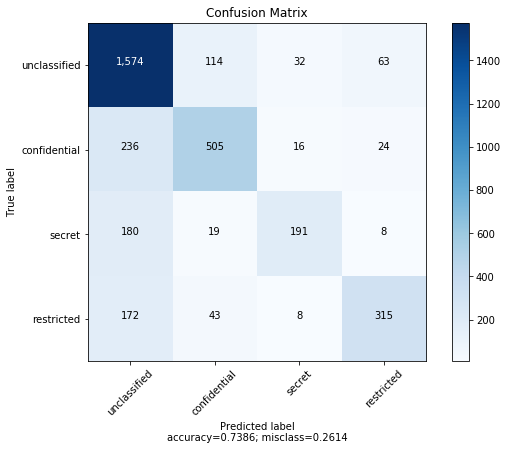

In [34]:
plot_confusion_matrix(cm,accuracy,misclass, normalize = False, 
                      target_names = ['unclassified', 'confidential', 'secret', 'restricted'], 
                      title = "Confusion Matrix" )